In [1]:
#yahoo finance as data source
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 63 kB 996 kB/s 
     |████████████████████████████████| 6.4 MB 2.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'AAPL'

In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-10,35.900002,35.970001,35.724998,35.792500,33.793835,75733600
2017-04-11,35.735001,35.837502,35.014999,35.407501,33.430347,121517600
2017-04-12,35.400002,35.537498,35.252499,35.450001,33.470474,81400000
2017-04-13,35.477501,35.595001,35.262501,35.262501,33.293438,71291600
2017-04-17,35.369999,35.470001,35.217499,35.457500,33.477547,66328400


In [6]:
len(data)

1260

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-04,174.570007,178.490005,174.440002,178.440002,178.440002,76468400
2022-04-05,177.500000,178.300003,174.419998,175.059998,175.059998,73401800
2022-04-06,172.360001,173.630005,170.130005,171.830002,171.830002,89058800
2022-04-07,171.160004,173.360001,169.850006,172.139999,172.139999,77594700
2022-04-08,171.779999,171.779999,169.199997,170.089996,170.089996,76515900


In [8]:
opn = data[['Open']]

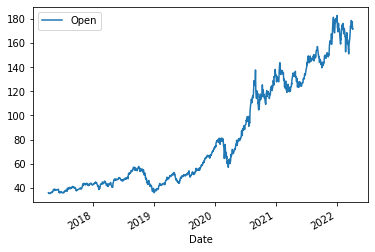

In [9]:
opn.plot()

In [10]:
import matplotlib.pyplot as plt

In [11]:
ds = opn.values

In [12]:
ds

array([[ 35.90000153],
       [ 35.73500061],
       [ 35.40000153],
       ...,
       [172.36000061],
       [171.16000366],
       [171.77999878]])

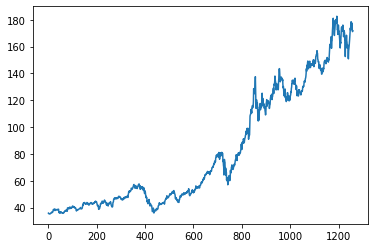

In [13]:
plt.plot(ds)

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [17]:
len(ds_scaled), len(ds)

(1260, 1260)

In [18]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [19]:
train_size,test_size

(882, 378)

In [20]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [21]:
len(ds_train),len(ds_test)

(882, 378)

In [22]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [23]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [24]:
X_train.shape,y_train.shape

((781, 100), (781,))

In [25]:
X_test.shape, y_test.shape

((277, 100), (277,))

In [26]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [28]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
13/13 [==============================] - 16s 645ms/step - loss: 0.0128 - val_loss: 0.0368
Epoch 2/100
13/13 [==============================] - 5s 370ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 3/100
13/13 [==============================] - 5s 342ms/step - loss: 9.3652e-04 - val_loss: 0.0070
Epoch 4/100
13/13 [==============================] - 4s 308ms/step - loss: 9.7036e-04 - val_loss: 0.0046
Epoch 5/100
13/13 [==============================] - 2s 180ms/step - loss: 8.9698e-04 - val_loss: 0.0073
Epoch 6/100
13/13 [==============================] - 2s 178ms/step - loss: 9.3049e-04 - val_loss: 0.0090
Epoch 7/100
13/13 [==============================] - 2s 180ms/step - loss: 7.9522e-04 - val_loss: 0.0050
Epoch 8/100
13/13 [==============================] - 2s 178ms/step - loss: 6.7380e-04 - val_loss: 0.0045
Epoch 9/100
13/13 [==============================] - 2s 179ms/step - loss: 6.2256e-04 - val_loss: 0.0054
Epoch 10/100
13/13 [==============================] - 2s 179ms

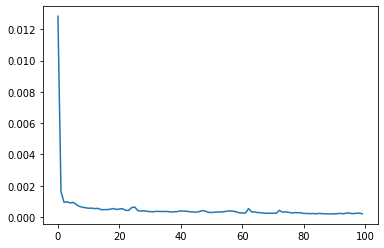

In [30]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [31]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [32]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

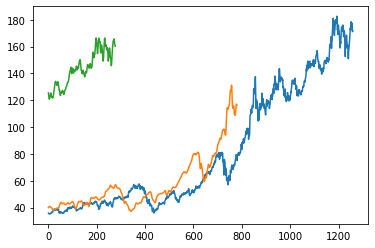

In [33]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [34]:
type(train_predict)

numpy.ndarray

In [35]:
test = np.vstack((train_predict,test_predict))

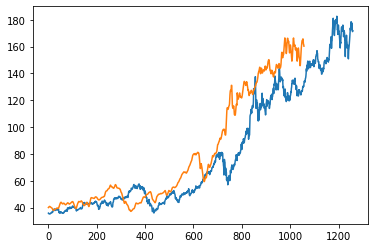

In [36]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [37]:
len(ds_test)

378

In [38]:
#Getting the last 100 days records
last_100 = len(ds_test)-100
fut_inp = ds_test[last_100:]

In [39]:
fut_inp = fut_inp.reshape(1,-1)

In [40]:
tmp_inp = list(fut_inp)

In [41]:
fut_inp.shape

(1, 100)

In [42]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [43]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.8319033980369568], [0.7991958856582642], [0.7562515735626221], [0.7143570780754089], [0.6783904433250427], [0.6500413417816162], [0.6295497417449951], [0.6164284944534302], [0.6098190546035767], [0.6087045669555664], [0.6120427846908569], [0.6188366413116455], [0.6281672120094299], [0.6392039060592651], [0.6512055993080139], [0.6635186076164246], [0.6755761504173279], [0.6868992447853088], [0.6970992684364319], [0.7058807015419006], [0.7130426168441772], [0.7184768319129944], [0.7221621870994568], [0.7241548299789429], [0.7245755791664124], [0.7235935926437378], [0.7214099764823914], [0.7182415723800659], [0.7143058776855469], [0.7098103165626526]]


In [44]:
len(ds_scaled)

1260

In [45]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

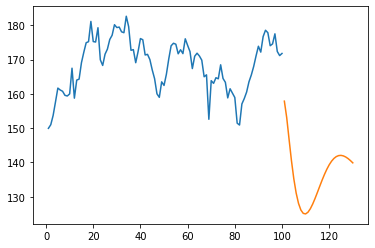

In [46]:
ds_scaled_minus_100 = len(ds_scaled) - 100
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[ds_scaled_minus_100:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [47]:
ds_new = ds_scaled.tolist()

In [48]:
len(ds_new)

1260

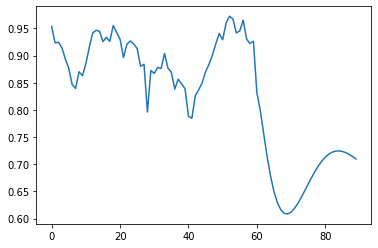

In [49]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [50]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

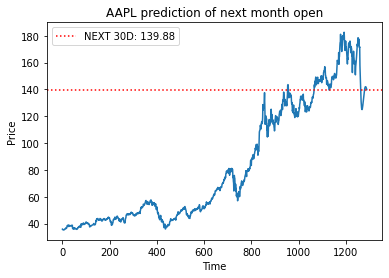

In [51]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

